# Introduction

This notebook demonstrates the application of kernel methods for local estimation.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (12, 8),
          'axes.labelsize': 20,
          'axes.titlesize': 24,
          'xtick.labelsize':16,
          'ytick.labelsize': 16}
mpl.rcParams.update(params)

%matplotlib inline

Load in the elemental dataset using pandas' read_csv method. This data was obtained from the Materials Project for the ground state structure of each element only. The columns are:
- K: Bulk modulus in GPa
- MP: Melting point in K
- BP: Boiling point in K
- Z: Atomic number
- X: Pauling electronegativity
- r: Atomic radius in angstroms

In [2]:
data = pd.read_csv("element_data.csv", index_col=0)
print(data.head())

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35


As you recall, we have earlier played around with this dataset in lecture 2 on linear methods. Using LASSO, we find that a good model can be obtained with just MP, BP and $\sqrt{X}$. Here we will use just these three variabels to do a kernel estimate for the bulk modulus.

In [3]:
data["sqrt(X)"] = data["X"] ** 0.5
features = ["MP", "BP", "sqrt(X)"]
x = data[features]
y = data["K"]

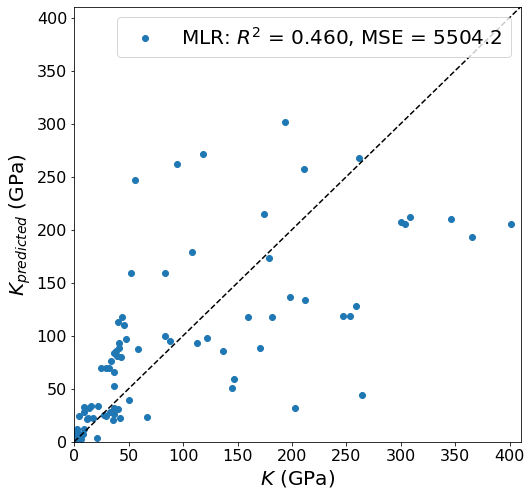

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsRegressor()
yhat_knn = cross_val_predict(knn, x, y, cv=kfold)
r2_knn = r2_score(y, yhat_knn)
mse_knn = mean_squared_error(y, yhat_knn)
label_knn = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_knn, mse_knn)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_knn, 'o', label=label_knn)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

Now, we have used the default number of nearest neighbors ($n$), which is 5 in scikit-learn. Quite possibly, this is not the optimal value. Often in data science, you need to do a **grid search** for optimal parameters. Using the average MSE as the criteria, we will now try to find an optimal value of $n$.

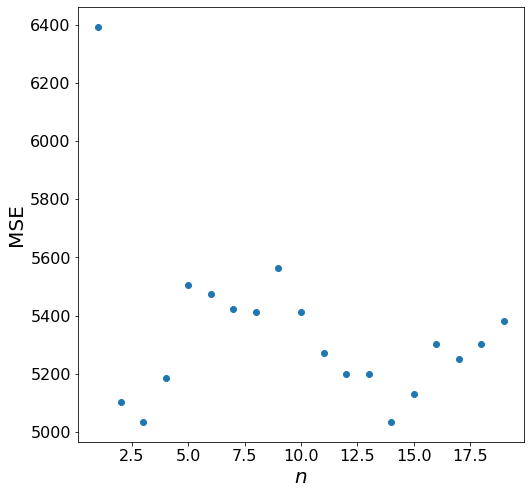

In [5]:
mses = []
for n in range(1, 20):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    knn = KNeighborsRegressor(n_neighbors=n)
    yhat_knn = cross_val_predict(knn, x, y, cv=kfold)
    r2_knn = r2_score(y, yhat_knn)
    mses.append((n, mean_squared_error(y, yhat_knn)))

mses = pd.DataFrame(mses, columns=["n", "MSE"])
    
f, ax = plt.subplots(figsize=(8, 8))
plt.plot(mses["n"], mses["MSE"], 'o')
plt.ylabel(r"MSE")
plt.xlabel(r"$n$");

Interesting, the optimal value of $n$ seems to be either 3, or 14.

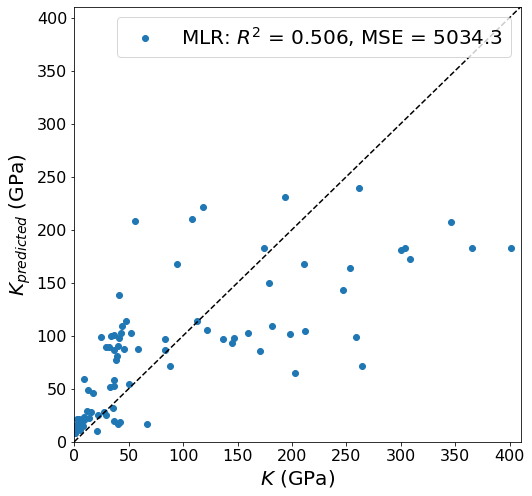

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsRegressor(n_neighbors=14)
yhat_knn = cross_val_predict(knn, x, y, cv=kfold)
r2_knn = r2_score(y, yhat_knn)
mse_knn = mean_squared_error(y, yhat_knn)
label_knn = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_knn, mse_knn)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_knn, 'o', label=label_knn)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

# Smooth kernels

It is rather difficult to visualize a function of three variables. For simplicity, we are now going to keep the electronegativity constant at a value of 2 (somewhere in the middle of the dataset), and plot the predicted $K$ as a function of the MP and BP.

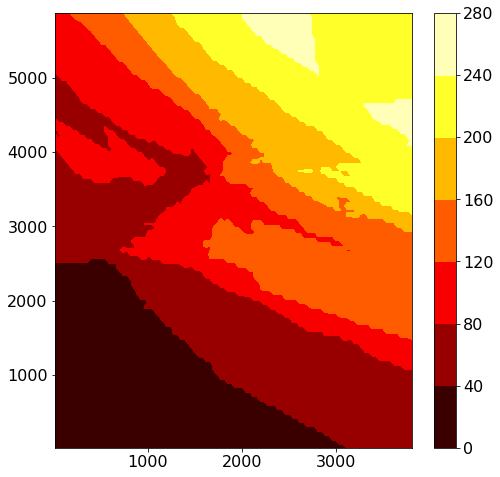

In [21]:
mps = np.linspace(min(data["MP"]), max(data["MP"]), 100)
bps = np.linspace(min(data["BP"]), max(data["BP"]), 100)
mps, bps = np.meshgrid(mps, bps)

import itertools
x_grid = pd.DataFrame({"MP": mps.ravel(), "BP": bps.ravel()})
x_grid["sqrt(X)"] = np.sqrt(2)
knn = KNeighborsRegressor(n_neighbors=14)
knn.fit(x, y)
k = np.zeros(mps.shape)
for i, j in itertools.product(range(mps.shape[0]), range(mps.shape[1])):
    k[i, j] = knn.predict([[mps[i, j], bps[i, j], 2]])

f, ax = plt.subplots(figsize=(8, 8))
plt.contourf(mps, bps, k, cmap=plt.cm.hot)
plt.colorbar();

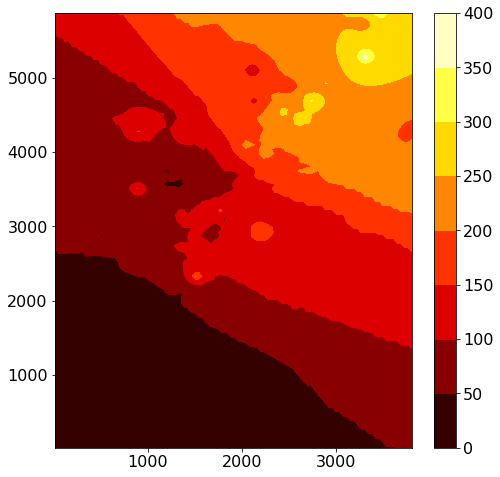

In [22]:
import itertools
x_grid = pd.DataFrame({"MP": mps.ravel(), "BP": bps.ravel()})
x_grid["sqrt(X)"] = np.sqrt(2)
knn = KNeighborsRegressor(n_neighbors=14, weights='distance')
knn.fit(x, y)
k = np.zeros(mps.shape)
for i, j in itertools.product(range(mps.shape[0]), range(mps.shape[1])):
    k[i, j] = knn.predict([[mps[i, j], bps[i, j], 2]])

f, ax = plt.subplots(figsize=(8, 8))
plt.contourf(mps, bps, k, cmap=plt.cm.hot)
plt.colorbar();